# Comment Classification: Normal, Insult, Obscenity, Threat

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import nltk
from nltk.corpus import stopwords
import os

C:\Users\User\anaconda3\envs\new\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\envs\new\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\User\anaconda3\envs\new\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [3]:
RS = 121212

In [4]:
sns.set_context('paper')
sns.set_style('whitegrid')

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
russian_stopwords = stopwords.words("russian")

In [7]:
data = []

with open('train.txt', 'r', encoding='UTF-8') as f:
    for line in f.readlines():
        parts = line.split('\t')
        data.append({
            'id':parts[0], 
            'text':parts[-1].strip(),
            'labels':parts[1:-1],
            'toxic':int(parts[1] != '__label__NORMAL')
        })
        
data = pd.DataFrame(data)
data.head()

,id,text,labels,toxic
0,41127,дворника надо тоже уничтожить!,[__label__THREAT],1
1,6812,"моя старшая неделю шипела, не принимала подкид...",[__label__NORMAL],0
2,6256,полностью с вами согласна!,[__label__NORMAL],0
3,189636,"хоть ногу вверх, ничего не изменится",[__label__NORMAL],0
4,99053,а что значит - левого ребенка?,[__label__NORMAL],0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      148775 non-null  object
 1   text    148775 non-null  object
 2   labels  148775 non-null  object
 3   toxic   148775 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.5+ MB


In [9]:
data.sample(5)

,id,text,labels,toxic
98007,81996,"прошу прощения,что уж влезла в ваш спор....реб...",[__label__NORMAL],0
9624,85259,это точно .у нас провода порвало.,[__label__NORMAL],0
25713,205835,всегда надо оставаться людьми.. выгнать и пнут...,[__label__NORMAL],0
109972,144638,бесплатный сыр только в мышеловке.пора уже зна...,[__label__NORMAL],0
26947,109790,цена где находитесь,[__label__NORMAL],0


In [10]:
data['toxic'].value_counts()

0    122194
1     26581
Name: toxic, dtype: int64

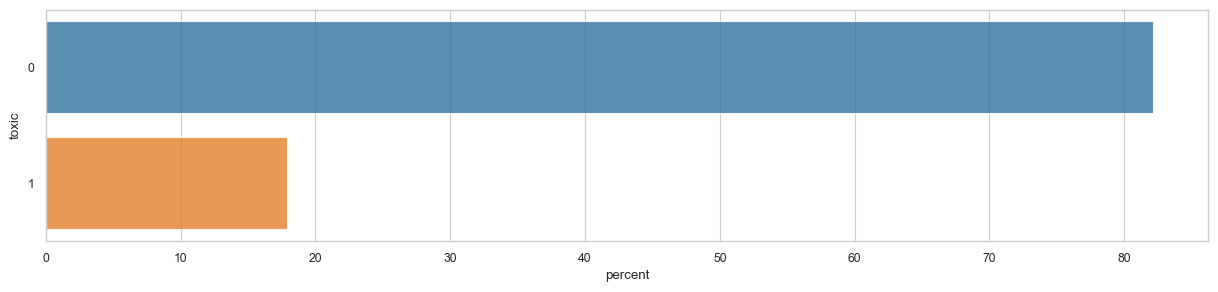

In [11]:
plt.figure(figsize=(15, 3))
sns.countplot(y=data['toxic'], stat='percent', hue=data['toxic'], legend=False, alpha=0.8)
plt.show()

In [12]:
data['labels'].value_counts()

[__label__NORMAL]                                         122194
[__label__INSULT]                                          17007
[__label__INSULT, __label__THREAT]                          3747
[__label__THREAT]                                           3263
[__label__OBSCENITY]                                        1323
[__label__INSULT, __label__OBSCENITY]                       1087
[__label__INSULT, __label__OBSCENITY, __label__THREAT]       111
[__label__OBSCENITY, __label__THREAT]                         43
Name: labels, dtype: int64

In [13]:
features_train, features_test, target_train, target_test = train_test_split(data['text'], data['toxic'], 
                                                                            test_size=0.2,
                                                                            random_state=RS)

In [14]:
features_train.shape

(119020,)

In [15]:
features_test.shape

(29755,)

In [16]:
target_train.shape

(119020,)

In [17]:
target_test.shape

(29755,)

## LogisticRegression 

In [18]:
pipe = make_pipeline(CountVectorizer(min_df=3, ngram_range=(1,1)),
                    LogisticRegression(max_iter=5000))

In [19]:
score = cross_val_score(pipe, features_train, target_train, scoring='roc_auc')

In [20]:
score.mean()

0.9703410844383964

In [21]:
pipe = make_pipeline(TfidfVectorizer(stop_words=russian_stopwords),
                    LogisticRegression(max_iter=5000))

In [22]:
score_tfidf = cross_val_score(pipe, features_train, target_train, scoring='roc_auc')

In [23]:
score_tfidf.mean()

0.9729054840637549

In [24]:
pipe.fit(features_train, target_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [25]:
preds = pipe.predict(features_test)

In [26]:
roc_auc_score(target_test, preds)

0.8374526685858449

## BERT

In [27]:
import torch

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

In [29]:
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict

from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import BertForSequenceClassification, AutoTokenizer

In [30]:
config = 'cointegrated/rubert-tiny2'

tokenizer = AutoTokenizer.from_pretrained(config)
model = BertForSequenceClassification.from_pretrained(config, num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
model.classifier

Linear(in_features=312, out_features=2, bias=True)

In [32]:
features_train1, features_val, target_train1, target_val = train_test_split(features_train, target_train, test_size=0.1,
                                                                          random_state=RS)

In [33]:
raw_data = DatasetDict({
    'train':Dataset.from_dict({'text':features_train1.tolist(), 'label':target_train1},),
    'valid':Dataset.from_dict({'text':features_val.tolist(), 'label':target_val}),
    'test':Dataset.from_dict({'text':features_test.tolist(), 'label':target_test})
})

In [34]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 107118
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 11902
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 29755
    })
})

In [35]:
tokenized_data = raw_data.map(lambda x: tokenizer(x['text']), batched=True, remove_columns=['text'])

In [36]:
args = TrainingArguments(
    'bert_clf',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.001,
    save_strategy='no',
    report_to='none',
)

In [37]:
def calc_metrics(pred):
    predictions, labels = pred
    pred_labels = np.argmax(predictions, axis=1)
    proba = np.exp(predictions)[:, 1] / np.exp(predictions).sum(1)
    
    return {
        'accuracy': np.mean(pred_labels==labels),
        'roc_auc': roc_auc_score(labels, proba)
    }

In [38]:
data_collator = DataCollatorWithPadding(tokenizer)

In [39]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['valid'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=calc_metrics
)

In [40]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.108300,0.104889,0.965384,0.989819
2,0.081900,0.091172,0.970593,0.992169
3,0.063300,0.099923,0.970509,0.992656


TrainOutput(global_step=10044, training_loss=0.09740847078560358, metrics={'train_runtime': 464.5313, 'train_samples_per_second': 691.781, 'train_steps_per_second': 21.622, 'total_flos': 499219928026128.0, 'train_loss': 0.09740847078560358, 'epoch': 3.0})

In [98]:
text = 'я посажу тебя в тюрьму у меня родственники очень влиятельные козел'

In [99]:
batch = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    out = model(**batch.to(model.device))
proba = torch.softmax(out.logits, axis=-1).cpu().numpy()
print(proba)

[[0.07406007 0.9259399 ]]


In [100]:
text = 'сегодня прекрасный день: свежо, морозно, вокруг лежит снег'

In [101]:
batch = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    out = model(**batch.to(model.device))
proba = torch.softmax(out.logits, axis=-1).cpu().numpy()
print(proba)

[[0.9993235  0.00067654]]


In [104]:
trainer.predict(tokenized_data['test'])

PredictionOutput(predictions=array([[ 3.567765 , -3.7840614],
       [-1.4163631,  1.4025418],
       [ 3.2852855, -3.5093794],
       ...,
       [ 3.349574 , -3.5674653],
       [ 3.6506734, -3.8427181],
       [ 3.5250635, -3.7417288]], dtype=float32), label_ids=array([0, 1, 0, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.08730626106262207, 'test_accuracy': 0.9733826247689464, 'test_roc_auc': 0.9938746929905539, 'test_runtime': 12.0025, 'test_samples_per_second': 2479.059, 'test_steps_per_second': 77.484})